# Fréchet Means of Persistence Diagrams of Context Vectors 

In what follows we will show a couple of example of computing the Fréchet mean of persistence diagrams. We start with a generic example and plot the results for several different `init` values for computing the barycenter diagram (a.k.a. the Fréchet mean diagram) using optimal transport. We then turn to a specific example of persistence diagrams obtained from computing the persistent homology of a subset of context vectors, computed by an individual attention head of `xlm-roberta-large`, corresponding to a collocation or multiword expression (like an idiom for example) inside of several text corpera. Note, you can substitute in the model of your choice in place of `xlm-roberta-large` so long as you can expose an individual attention head's weight matrices in some way (see code below for an example of how to do this for most BERT models). As a good first example, try substituting in `bert-base-multilingual-cased` for `xlm-roberta-large`. You can also try uncommenting some of the print statements in the code for `compute_phrase_distances_and_homology` to see the persistence diagrams for the multiword expression "the tip of the iceberg" in four different contexts. 

In [112]:
pip install numpy matplotlib scikit-learn gudhi pot -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [113]:
# You may need to run this to get the code to work
# conda install pot -q

## An Initial Generic Example of the Fréchet Mean of Persistence Diagrams (a.k.a. the Barycenter Persistence Diagram)

In [114]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import numpy as np

dg1 = np.array([[0., 1.], [0, 2], [1, 2], [1.32, 1.87], [0.7, 1.2]])
dg2 = np.array([[0, 1.5], [0.5, 2], [1.2, 2], [1.3, 1.8], [0.4, 0.8]])
dg3 = np.array([[0.2, 1.1], [0.1, 2.2], [1.3, 2.1], [0.5, 0.9], [0.6, 1.1]])
dg4 = np.array([])
pdiagset = [dg1, dg2, dg3, dg4]
bary = lagrangian_barycenter(pdiagset=pdiagset,init=3)

print("Wasserstein barycenter estimated:")
print(bary)


Wasserstein barycenter estimated:
[[0.5375     1.1625    ]
 [1.275      1.925     ]
 [0.29583333 0.87083333]
 [1.44125    1.70375   ]
 [0.65       0.75      ]
 [0.43333333 1.83333333]]


## Another Generic Example with Plots

In [115]:
import gudhi
print("Current gudhi version:", gudhi.__version__)
print("Version >= 3.2.0 is required for this tutorial")

Current gudhi version: 3.8.0
Version >= 3.2.0 is required for this tutorial


In [116]:
# Note: %matplotlib notebook allows for iteractive 3D plot.
#%matplotlib notebook
%matplotlib inline

In [117]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter as bary
from gudhi.persistence_graphical_tools import plot_persistence_diagram

import numpy as np
import matplotlib.pyplot as plt

In [118]:
diag1 = np.array([[0., 1.], [0, 2], [1, 2], [1.32, 1.87], [0.7, 1.2]])
diag2 = np.array([[0, 1.5], [0.5, 2], [1.2, 2], [1.3, 1.8], [0.4, 0.8]])
diag3 = np.array([[0.2, 1.1], [0.1, 2.2], [1.3, 2.1], [0.5, 0.9], [0.6, 1.1]])

diags = [diag1, diag2, diag3]

Text(0.5, 1.0, 'Set of 3 persistence diagrams')

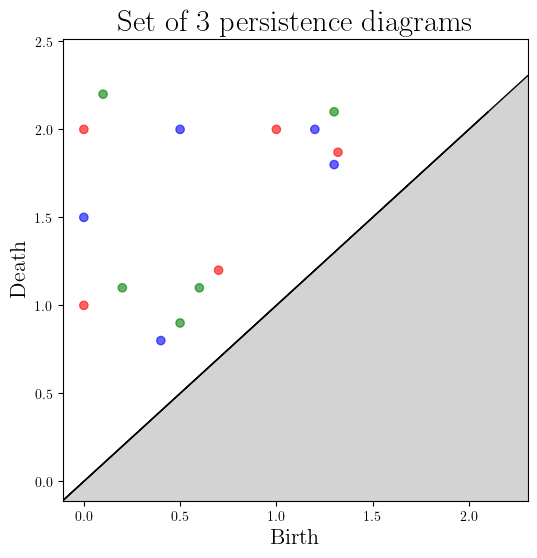

In [119]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors=['r', 'b', 'g']
for diag, c in zip(diags, colors):
    plot_persistence_diagram(diag, axes=ax, colormap=c)
ax.set_title("Set of 3 persistence diagrams", fontsize=22)


In [120]:
b, log = bary(diags, 
         init=0,
         verbose=True)  # we initialize our estimation on the first diagram (the red one.)

print("Energy reached by this estimation of the barycenter: E=%.2f." %log['energy'])
print("Convergenced made after %s steps." %log['nb_iter'])

Energy reached by this estimation of the barycenter: E=0.47.
Convergenced made after 2 steps.


In [121]:
G = log["groupings"]

def proj_on_diag(x):
    return ((x[1] + x[0]) / 2, (x[1] + x[0]) / 2)

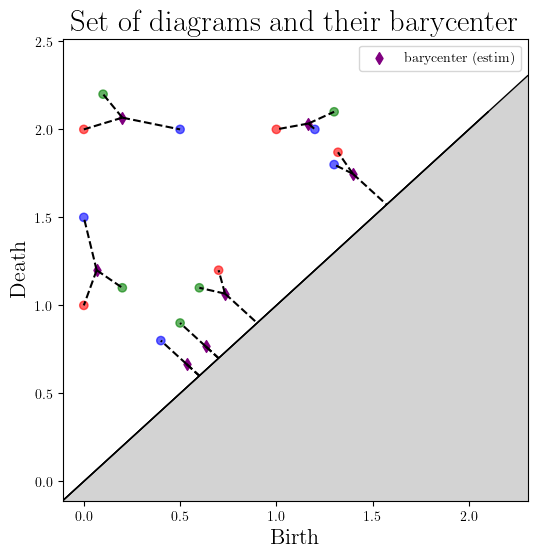

In [122]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors = ['r', 'b', 'g']

for diag, c in zip(diags, colors):
    plot_persistence_diagram(diag, axes=ax, colormap=c)

def plot_bary(b, diags, groupings, axes):
    # n_y = len(Y.points)
    for i in range(len(diags)):
        indices = G[i]
        n_i = len(diags[i])

        for (y_j, x_i_j) in indices:
            y = b[y_j]
            if y[0] != y[1]:
                if x_i_j >= 0:  # not mapped with the diag
                    x = diags[i][x_i_j]
                else:  # y_j is matched to the diagonal
                    x = proj_on_diag(y)
                ax.plot([y[0], x[0]], [y[1], x[1]], c='black',
                        linestyle="dashed")

    ax.scatter(b[:,0], b[:,1], color='purple', marker='d', label="barycenter (estim)")
    ax.legend()
    ax.set_title("Set of diagrams and their barycenter", fontsize=22)

plot_bary(b, diags, G, axes=ax)


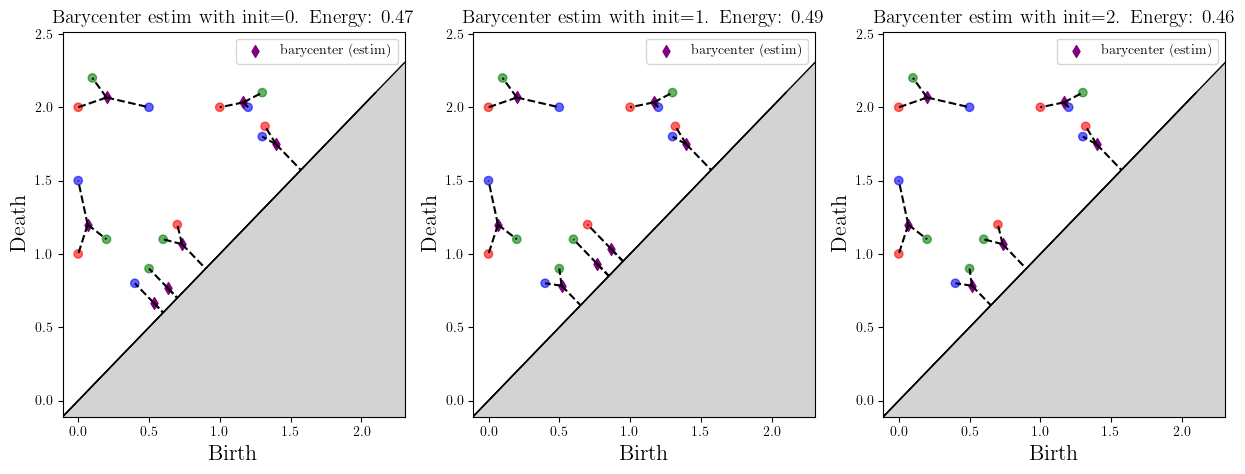

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

colors = ['r', 'b', 'g']

for i, ax in enumerate(axs):
    for diag, c in zip(diags, colors):
        plot_persistence_diagram(diag, axes=ax, colormap=c)

    b, log = bary(diags, init=i, verbose=True)
    e = log["energy"]
    G = log["groupings"]
    # print(G)
    plot_bary(b, diags, groupings=G, axes=ax)
    ax.set_title("Barycenter estim with init=%s. Energy: %.2f" %(i, e), fontsize=14)

## Barycenter Example with Four Texts in English

In what follows we will compute the Fréchet mean (or barycenter) of four persistence diagrams obatined from computing the persistent homology of the context vectors computed by an individual attention head of `xlm-roberta-large`. 

In [124]:
text = ["Quantum information theory is a vast field that delves into the mechanics of information in the quantum realm, using principles of quantum physics to redefine our understanding of information processing. However, what we currently comprehend about quantum information theory is just the tip of the iceberg. As we venture deeper into this realm, we are likely to encounter new phenomena, such as quantum entanglement and superposition, that are far removed from our classical understanding of information transmission. Quantum computers, for instance, promise an information processing revolution, but their full potential and the underlying complexities of quantum states and their manipulation remain elusive. As researchers continue to explore these quantum depths, we can expect quantum information theory to provide transformative impacts across numerous fields, from cryptography to machine learning."]

text_2 = ["Language morphology, the study of the internal structure of words, is an equally captivating field. The languages we speak today, with their intricate rules and exceptions, are merely the tip of the iceberg. Underneath the surface of everyday conversation lie complex systems of morphemes - the smallest units of meaning - that combine to form words and express nuanced concepts. Inflectional morphemes modify a word's tense, number, or case, while derivational morphemes can change a word's meaning or part of speech entirely. This intricate structure is hidden beneath the surface of spoken and written language, often unnoticed by casual speakers. As linguists continue to delve into the depths of language morphology, they uncover fascinating patterns and structures that deepen our understanding of human communication."]

text_3 = ["Quantum information theory is a vast field that delves into the mechanics of information in the quantum realm, using principles of quantum physics to redefine our understanding of information processing. However, what we currently comprehend about quantum information theory is just the tip of the iceberg. As we venture deeper into this realm, we are likely to encounter new phenomena, such as quantum entanglement and superposition, that are far removed from our classical understanding of information transmission. Quantum computers, for instance, promise an information processing revolution, but their full potential and the underlying complexities of quantum states and their manipulation remain elusive. As researchers continue to explore these quantum depths, we can expect quantum information theory to provide transformative impacts across numerous fields, from cryptography to machine learning."]

text_4 = ["Language morphology, the study of the internal structure of words, is an equally captivating field. The languages we speak today, with their intricate rules and exceptions, are merely the tip of the iceberg. Underneath the surface of everyday conversation lie complex systems of morphemes - the smallest units of meaning - that combine to form words and express nuanced concepts. Inflectional morphemes modify a word's tense, number, or case, while derivational morphemes can change a word's meaning or part of speech entirely. This intricate structure is hidden beneath the surface of spoken and written language, often unnoticed by casual speakers. As linguists continue to delve into the depths of language morphology, they uncover fascinating patterns and structures that deepen our understanding of human communication."]


In [125]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel


def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
    model = AutoModel.from_pretrained("xlm-roberta-large") 


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
context_2 = [compute_output(t, layer, head) for t in text_2]
context_3 = [compute_output(t, layer, head) for t in text_3]
context_4 = [compute_output(t, layer, head) for t in text_4]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

## Computing the Persistent Homology of the Collocation or Multiword Expression

In [126]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    # print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    # print(f'Distance matrix: {distances.shape}')
    # print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    # gd.plot_persistence_diagram(persistence=persistent_homology)
    # plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
diag1 = compute_phrase_distances_and_homology(context[0], text[0], "the tip of the iceberg")
diag2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "the tip of the iceberg")
diag3 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "the tip of the iceberg")
diag4 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "the tip of the iceberg")

In [127]:
print(type(diag1))
print(diag1)

<class 'list'>
[(0, (0.0, inf)), (0, (0.0, 0.18599958331220276)), (0, (0.0, 0.11677755236070866)), (0, (0.0, 0.09797088350042026)), (0, (0.0, 0.0837447875514504)), (0, (0.0, 0.06384728187412174)), (0, (0.0, 0.06109672421986496))]


In [128]:
def convert_persistence_diagram(diagram):
    return np.array([point[1] for point in diagram if point[1][1] != np.inf])

# Convert your diagrams
dg1 = convert_persistence_diagram(diag1)
dg2 = convert_persistence_diagram(diag2)
dg3 = convert_persistence_diagram(diag3)
dg4 = convert_persistence_diagram(diag4)

# Now try the barycenter computation again
pdiagset = [dg1, dg2, dg3, dg4]
bary = lagrangian_barycenter(pdiagset=pdiagset,init=3)
print(bary)


[[0.         0.19511141]
 [0.         0.14570137]
 [0.         0.11616633]
 [0.         0.08047934]
 [0.         0.06964863]
 [0.         0.058938  ]]


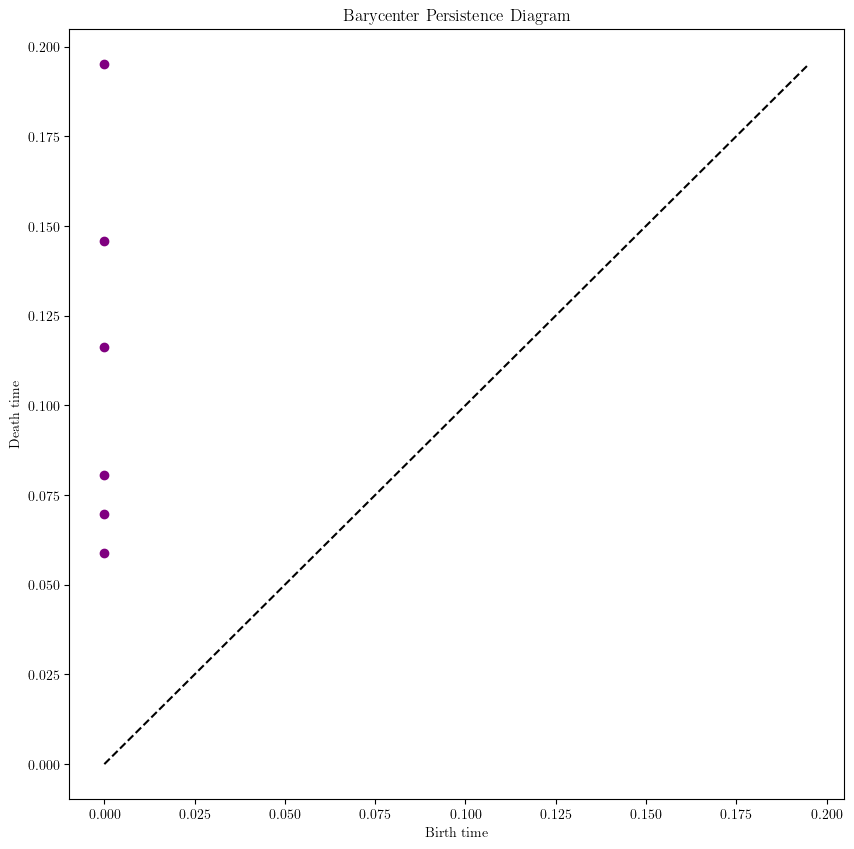

In [129]:
import matplotlib.pyplot as plt

# Convert the barycenter back into a list of tuples format
bary_as_tuples = [(0, tuple(point)) for point in bary]

# Separate birth and death times for plotting
birth_times, death_times = zip(*[point[1] for point in bary_as_tuples])

plt.figure(figsize=(10,10))
plt.scatter(birth_times, death_times, color='purple')
plt.plot([0, max(death_times)], [0, max(death_times)], 'k--')  # diagonal line
plt.title('Barycenter Persistence Diagram')
plt.xlabel('Birth time')
plt.ylabel('Death time')
plt.show()


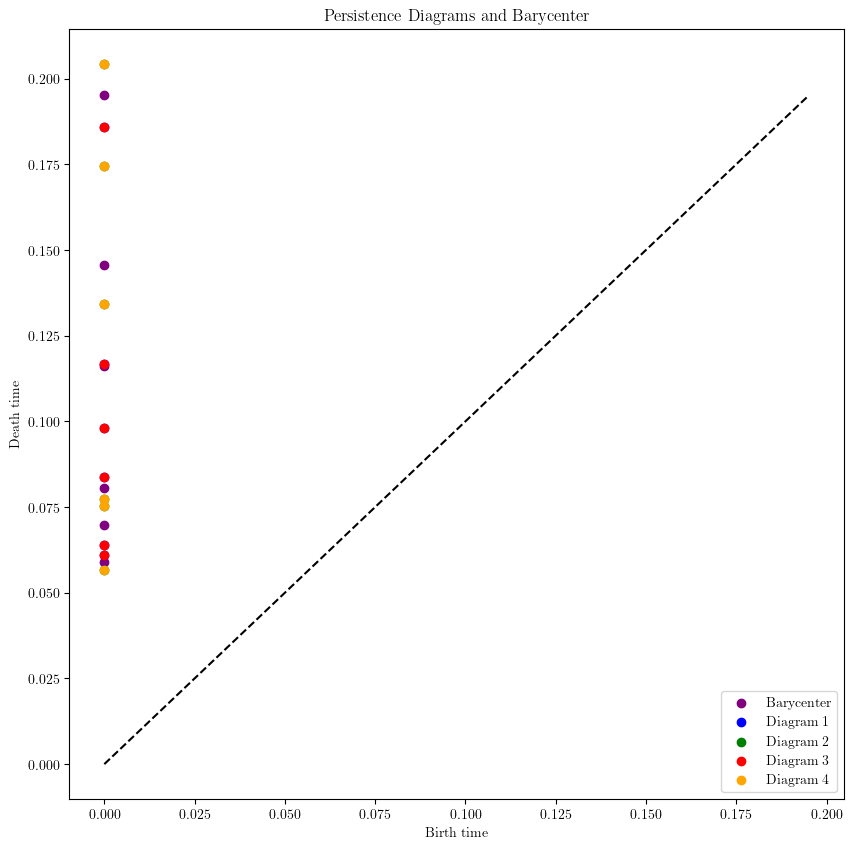

In [130]:
import matplotlib.pyplot as plt

# Convert the barycenter back into a list of tuples format
bary_as_tuples = [(0, tuple(point)) for point in bary]

# Separate birth and death times for plotting
birth_times_bary, death_times_bary = zip(*[point[1] for point in bary_as_tuples])

plt.figure(figsize=(10,10))

# Plot the barycenter
plt.scatter(birth_times_bary, death_times_bary, color='purple', label='Barycenter')

# Plot the original diagrams
colors = ['blue', 'green', 'red', 'orange']
for idx, diag in enumerate([dg1, dg2, dg3, dg4]):
    birth_times, death_times = zip(*diag)
    plt.scatter(birth_times, death_times, color=colors[idx], label=f'Diagram {idx+1}')

plt.plot([0, max(death_times_bary)], [0, max(death_times_bary)], 'k--')  # diagonal line
plt.title('Persistence Diagrams and Barycenter')
plt.xlabel('Birth time')
plt.ylabel('Death time')
plt.legend()
plt.show()


In this notebook, we should now discuss the possibility of averaging multiple barcodes or persistence diagrams for the context vectors associated to a collocation or multiword expression. We do this in order to find an average topological structure of a collocation or multiword expression, represented in many different contexts with each context containing roughly the same number of tokens. Finding such an average topological structure would then allow us to use its persistence diagram or barcode as a reference point in the space of all persistence diagrams when including persistent homology in the objective of a large language model during pretraining, effectively encouraging the model to learn contextual representations of the collocation or multiword expression that have similar persistent topological features to this mean topological structure. To do this, we need the concept of Fréchet mean; since the space of persistence diagrams is not a linear space, we cannot simply take the arithmetic mean.

Note, this does not restrict the individual context vectors for each token of the collocation or MWE, nor does it impose any direct restrictions on the other tokens' context vectors. It only imposes a restriction on the relative distances between the context vectors of the collocation or MWE, so that the persistent homology is preserved, relative to some average that can be computed for many different contexts. This will encourage the model to learn a topological representation of the context vectors that is more stable across different contexts, which as we have already seen, is a behavior that models better at many multilingual tasks exhibit. 

Conjecturally, this may be important in multilingual tasks such as machine translation, as models that are known to perform better at preserving the persistent homology also perform better at translation tasks. This could provide a way of boosting performance of smaller models that have not learned topologically stable representations of collocations and multiword expressions. Note, this could be used to train or fine tune single attention heads that detect collocations, MWE, or idioms, and using Low Rank Adaptations we may be able to accomplish this even after the fine-tuning phase, especially if we find that some subset of attention heads already preserved the persistent homology of collocations, or MWEs better than others. 